# Create Insertion Window

**Purpose:** In order to stabilize the brain during the experiment, we use a plastic window with pre-cut holes for the probes to pass through. This notebook will automatically generate a design file that can be used to laser cut a window for a specific set of probes and target locations.

**Prerequisites:** 
1. A calibration file (`calibration_info.py`) with the measured global and local coordinates at each calibration point
2. A set of targets (in global coordinate space) for each probe

In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

import ezdxf as dxf
from svgpathtools import svg2paths, Line, Arc, CubicBezier

import rotations # local Python file
import calibration_info # local Python file

First, let's set the parameters for our insertion window, along with the target coordinates:

In [2]:
# window material thickness (in mm)
plastic_window_thickness = 500

# glass coverslip thickness (in mm)
coverslip_thickness = 475

# distance between the bottom surface of the insertion window and the plane of the reticle 
bottom_surface_height = 1.5

# radius of the insertion window holes (in mm)
hole_radius = 0.5

# name of the output file
output_file = 'window.dxf'

# window type (single_level or tiered)
window_type = 'single_level'

# target coordinates (in mm from the center of the reticle)
targets = { }
targets['probeA'] = [-2,0,0]
targets['probeB'] = [-1,1.5,0]
targets['probeC'] = [0,2,0]
targets['probeD'] = [1.5,1.5,0]
targets['probeE'] = [2,0,0]
targets['probeF'] = [1,-1,0]

# colors for each probe
colors = ('red', 'orange', 'brown', 'green', 'blue', 'purple')

Now, we load the premade window outline and initialize the DXF drawing we will use to hold the final window design:

In [3]:
if window_type == 'single_level':
    paths, attributes = svg2paths('window_outline.svg')
else:
    paths, attributes = svg2paths('window_outline_tiered.svg')

drawing = dxf.new()
modelspace = drawing.modelspace()

Next, we add the features to the DXF drawing (and also plot them using `matplotlib`):

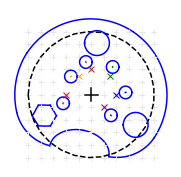

In [4]:
# import the global and local coordinates of our calibration poitns
calibrationInfo = calibration_info.getCalibrationInfo()

plt.figure(figsize=(3,3))

center = [33.4, 29]
mm_per_px = 14.61/41.413
angles = np.linspace(0,2*np.pi,30)

DXFCOLOR = 0
DXFLINEWIDTH = 0.01
scale_outline = 0.99

bottom_surface_probe_distance = (bottom_surface_height + coverslip_thickness/1000)*1.1
top_surface_probe_distance = bottom_surface_height + plastic_window_thickness/1000*1.1 # works better than 100%

# extract the default window outline
for superpath in paths:

    for idx, path in enumerate(superpath):

        if type(path) == CubicBezier:
            p = path.poly()
            x = np.linspace(0,1,30)
            y = p(x)
            x = -(np.real(y) - center[0])*mm_per_px * scale_outline
            y = -(np.imag(y) - center[1])*mm_per_px * -1 * scale_outline
            vertices = []
            for i in range(x.size):
                vertices.append((x[i],y[i]))
            modelspace.add_lwpolyline(vertices)
            plt.plot(x,y,color='b')
        else:
            if (type(path) != Arc):
                x = -(np.array([path[0].real, path[1].real]) - center[0]) * mm_per_px
                y = -(np.array([path[0].imag, path[1].imag]) - center[1]) * mm_per_px * -1
                modelspace.add_line((x[0],y[0]),(x[1],y[1]))
                plt.plot(x, y, 'b')

# draw a 1 mm grid (matplotlib only):
for x in range(-5,6):
    for y in range(-5,6):
        plt.plot(x,y,'+',color='0.9')
        
# compute the locations at which each probe passes through the window, 
# and create the relevant holes:
for key, color in zip(calibrationInfo.keys(), colors):

    origin, R = rotations.fit_params(calibrationInfo[key]['global_coords'], 
                                     calibrationInfo[key]['local_coords'])

    target = np.array(targets[key]).T 

    coords = (np.dot(target + origin, R) + np.array([3,3,3]))
    invRotMat = np.linalg.inv(R)
    local_pt = coords - np.array([3,3,3])
    insertion_pt = np.dot(local_pt, invRotMat) - origin

    local_pt_bottom = local_pt + [0,0,(-bottom_surface_probe_distance)]
    global_pt_bottom = np.dot(local_pt_bottom, invRotMat) - origin
    local_pt_middle = local_pt + [0,0,-np.mean([bottom_surface_probe_distance,top_surface_probe_distance])]
    global_pt_middle = np.dot(local_pt_middle, invRotMat) - origin

    r = hole_radius
    xp = r*np.cos(angles) + global_pt_middle[0]
    yp = r*np.sin(angles) + global_pt_middle[1]
    plt.plot(xp, yp, '-b')
    
    modelspace.add_circle(center=(global_pt_middle[0], global_pt_middle[1]),
                          radius=r)

    local_pt_top = local_pt + [0,0,-top_surface_probe_distance]
    global_pt_top = np.dot(local_pt_top, invRotMat) - origin

    plt.plot(insertion_pt[0],
             insertion_pt[1],
             'x',color=color)
    
    plt.plot([global_pt_bottom[0],
              global_pt_top[0]],
             [global_pt_bottom[1],
              global_pt_top[1]],
              color)

# draw guidelines indicating the radius of the 
# glass coverslip
r = 5
xp = -r*np.cos(angles)
yp = -r*np.sin(angles)
plt.plot(xp, yp, '--k')
modelspace.add_circle(center=(0,0), radius=r)

# place holes for agarose
r = 2.8 * mm_per_px
x_offset = (32.1 - center[0]) * mm_per_px
y_offset = - (40.6 - center[1]) * mm_per_px
xp = -(r*np.cos(angles) + x_offset)
yp = -(r*np.sin(angles) + y_offset)
plt.plot(xp, yp, '-b')
modelspace.add_circle(center=(-x_offset,-y_offset),
                      radius=r)

x_offset = (23.4 - center[0]) * mm_per_px
y_offset = - (22.2 - center[1]) * mm_per_px
xp = -(r*np.cos(angles) + x_offset)
yp = -(r*np.sin(angles) + y_offset)
plt.plot(xp, yp, '-b')
modelspace.add_circle(center=(-x_offset,-y_offset),
                      radius=r)

# draw center point:
plt.plot([0,0],[-0.5,0.5],'-k')
plt.plot([-0.5,0.5],[0,0],'-k')
plt.gca().invert_xaxis()
plt.gca().invert_yaxis()
plt.axis('off')

plt.xlim([-10,60])
plt.ylim([-10,60])
plt.axis('equal')

# save the DXF drawing to a file:
drawing.saveas(output_file)

As a final step, open the .dxf file in Illustrator or Inkscape, and format it for your preferred laser cutting manufacturer.

For Ponoko, this involves setting the line color to blue (R=0, G=0, B=255) and the stroke width to 0.01 mm. You can then make multiple copies of the window and/or add windows for additional mice.